<a href="https://colab.research.google.com/github/NicolasRuiz889/Proyecto_final_sistemas_distribuidos_2025/blob/main/Copia_de_Archivo_final_forecast.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install statsmodels

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose, STL
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.stats.diagnostic import acorr_ljungbox
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [ ]:
# 1) Carga y preparación de la serie
df = pd.read_csv('data_jam.csv')

In [ ]:
df.head()

,DATE_S - Año,DATE_S - Mes,DATE_S - Día,Interval_Group,FCST Calls,OFF Calls,'Medidas'[D_Calls%],Handled Calls,FCST AHT,Real AHT,...,O/U Req Real,Calls in TSF,FCST TSF,Real TSF,FCST ABA,Real ABA,FCST ABA%,Real ABA%,FCST ASA,Real ASA
0,2021,abril,1,0:00,9,12,33.30%,10,510,325,...,0,5,0%,42%,2,2,22.22%,16.70%,284,215
1,2021,abril,1,0:30,5,12,140.00%,6,405,1109,...,-7,2,25%,17%,0,6,0.00%,50.00%,47,109
2,2021,abril,1,1:00,8,7,-12.50%,6,365,476,...,-1,1,3%,14%,1,1,12.50%,14.30%,135,452
3,2021,abril,1,1:30,3,6,100.00%,6,552,557,...,-1,5,35%,83%,0,0,0.00%,0.00%,33,12
4,2021,abril,1,2:00,3,6,100.00%,6,395,345,...,0,5,50%,83%,0,0,0.00%,0.00%,17,20


In [ ]:
month_map = {
    'enero':1,'febrero':2,'marzo':3,'abril':4,
    'mayo':5,'junio':6,'julio':7,'agosto':8,
    'septiembre':9,'octubre':10,'noviembre':11,'diciembre':12
}

In [ ]:
df.head()

,DATE_S - Año,DATE_S - Mes,DATE_S - Día,Interval_Group,FCST Calls,OFF Calls,'Medidas'[D_Calls%],Handled Calls,FCST AHT,Real AHT,...,O/U Req Real,Calls in TSF,FCST TSF,Real TSF,FCST ABA,Real ABA,FCST ABA%,Real ABA%,FCST ASA,Real ASA
0,2021,abril,1,0:00,9,12,33.30%,10,510,325,...,0,5,0%,42%,2,2,22.22%,16.70%,284,215
1,2021,abril,1,0:30,5,12,140.00%,6,405,1109,...,-7,2,25%,17%,0,6,0.00%,50.00%,47,109
2,2021,abril,1,1:00,8,7,-12.50%,6,365,476,...,-1,1,3%,14%,1,1,12.50%,14.30%,135,452
3,2021,abril,1,1:30,3,6,100.00%,6,552,557,...,-1,5,35%,83%,0,0,0.00%,0.00%,33,12
4,2021,abril,1,2:00,3,6,100.00%,6,395,345,...,0,5,50%,83%,0,0,0.00%,0.00%,17,20


In [ ]:
df['hora'] = df['Interval_Group'].str.split('-').str[0]

In [ ]:
df['fecha'] = pd.to_datetime(
    df['DATE_S - Año'].astype(str) + '-' +
    df['DATE_S - Mes'].str.lower().map(month_map).astype(str).str.zfill(2) + '-' +
    df['DATE_S - Día'].astype(str).str.zfill(2) + ' ' + df['hora'],
    format='%Y-%m-%d %H:%M')

In [ ]:
df.head(800000)

,DATE_S - Año,DATE_S - Mes,DATE_S - Día,Interval_Group,FCST Calls,OFF Calls,'Medidas'[D_Calls%],Handled Calls,FCST AHT,Real AHT,...,FCST TSF,Real TSF,FCST ABA,Real ABA,FCST ABA%,Real ABA%,FCST ASA,Real ASA,hora,fecha
0,2021,abril,1,0:00,9,12,33.30%,10,510,325,...,0%,42%,2,2,22.22%,16.70%,284,215,0:00,2021-04-01 00:00:00
1,2021,abril,1,0:30,5,12,140.00%,6,405,1109,...,25%,17%,0,6,0.00%,50.00%,47,109,0:30,2021-04-01 00:30:00
2,2021,abril,1,1:00,8,7,-12.50%,6,365,476,...,3%,14%,1,1,12.50%,14.30%,135,452,1:00,2021-04-01 01:00:00
3,2021,abril,1,1:30,3,6,100.00%,6,552,557,...,35%,83%,0,0,0.00%,0.00%,33,12,1:30,2021-04-01 01:30:00
4,2021,abril,1,2:00,3,6,100.00%,6,395,345,...,50%,83%,0,0,0.00%,0.00%,17,20,2:00,2021-04-01 02:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71711,2025,mayo,5,21:30,56,74,32.10%,32,614,787,...,0%,8%,24,42,42.86%,56.80%,364,700,21:30,2025-05-05 21:30:00
71712,2025,mayo,5,22:00,46,75,63.00%,35,668,677,...,0%,13%,20,40,43.48%,53.30%,412,629,22:00,2025-05-05 22:00:00
71713,2025,mayo,5,22:30,36,53,47.20%,29,675,686,...,69%,9%,7,24,19.44%,45.30%,406,523,22:30,2025-05-05 22:30:00
71714,2025,mayo,5,23:00,23,57,147.80%,39,572,722,...,0%,11%,10,18,43.48%,31.60%,352,282,23:00,2025-05-05 23:00:00


In [ ]:
df['OFF Calls'] = pd.to_numeric(df['OFF Calls'], errors='coerce')

In [ ]:
df.dtypes

,0
DATE_S - Año,int64
DATE_S - Mes,object
DATE_S - Día,int64
Interval_Group,object
FCST Calls,int64
OFF Calls,int64
'Medidas'[D_Calls%],object
Handled Calls,int64
FCST AHT,int64
Real AHT,int64


In [ ]:
df = df.dropna(subset=['OFF Calls'])

In [ ]:
df.head(800000)

,DATE_S - Año,DATE_S - Mes,DATE_S - Día,Interval_Group,FCST Calls,OFF Calls,'Medidas'[D_Calls%],Handled Calls,FCST AHT,Real AHT,...,FCST TSF,Real TSF,FCST ABA,Real ABA,FCST ABA%,Real ABA%,FCST ASA,Real ASA,hora,fecha
0,2021,abril,1,0:00,9,12,33.30%,10,510,325,...,0%,42%,2,2,22.22%,16.70%,284,215,0:00,2021-04-01 00:00:00
1,2021,abril,1,0:30,5,12,140.00%,6,405,1109,...,25%,17%,0,6,0.00%,50.00%,47,109,0:30,2021-04-01 00:30:00
2,2021,abril,1,1:00,8,7,-12.50%,6,365,476,...,3%,14%,1,1,12.50%,14.30%,135,452,1:00,2021-04-01 01:00:00
3,2021,abril,1,1:30,3,6,100.00%,6,552,557,...,35%,83%,0,0,0.00%,0.00%,33,12,1:30,2021-04-01 01:30:00
4,2021,abril,1,2:00,3,6,100.00%,6,395,345,...,50%,83%,0,0,0.00%,0.00%,17,20,2:00,2021-04-01 02:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71711,2025,mayo,5,21:30,56,74,32.10%,32,614,787,...,0%,8%,24,42,42.86%,56.80%,364,700,21:30,2025-05-05 21:30:00
71712,2025,mayo,5,22:00,46,75,63.00%,35,668,677,...,0%,13%,20,40,43.48%,53.30%,412,629,22:00,2025-05-05 22:00:00
71713,2025,mayo,5,22:30,36,53,47.20%,29,675,686,...,69%,9%,7,24,19.44%,45.30%,406,523,22:30,2025-05-05 22:30:00
71714,2025,mayo,5,23:00,23,57,147.80%,39,572,722,...,0%,11%,10,18,43.48%,31.60%,352,282,23:00,2025-05-05 23:00:00


In [ ]:
ts = df.set_index('fecha')['OFF Calls'].sort_index()

In [ ]:
ts.head()

,OFF Calls
fecha,
2021-04-01 00:00:00,12
2021-04-01 00:30:00,12
2021-04-01 01:00:00,7
2021-04-01 01:30:00,6
2021-04-01 02:00:00,6


In [ ]:
# 2) Análisis previo
## 2.1 Valores faltantes y descriptivos
print("Missing:", ts.isnull().sum())
print(ts.describe())

Missing: 0
count    71716.000000
mean       120.062427
std        136.268093
min          0.000000
25%         15.000000
50%         60.000000
75%        183.000000
max        908.000000
Name: OFF Calls, dtype: float64


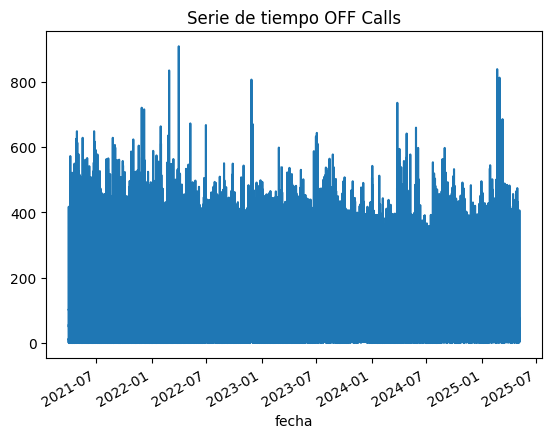

In [ ]:
## 2.2 Serie de tiempo
plt.figure(); ts.plot(title='Serie de tiempo OFF Calls'); plt.show()

In [ ]:
## 2.3 Prueba ADF (serie original)
adf_stat, pval, *_ = adfuller(ts)
print(f"ADF: {adf_stat:.3f}, p-value: {pval:.3f}")

In [ ]:
## 2.4 ACF/PACF de la serie
plt.figure(); plot_acf(ts, lags=50); plt.title('ACF OFF Calls'); plt.show()
plt.figure(); plot_pacf(ts, lags=50, method='ywm'); plt.title('PACF OFF Calls'); plt.show()

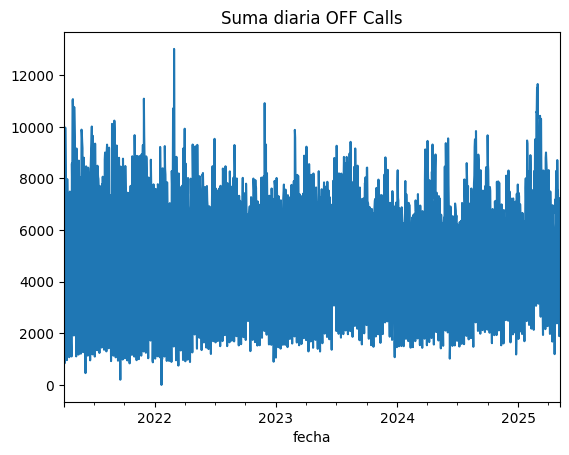

In [ ]:
# 3) Muestreo diario y descomposición
daily = ts.resample('D').sum()
plt.figure(); daily.plot(title='Suma diaria OFF Calls'); plt.show()

In [ ]:
## 3.1 ADF en diaria
adf_stat_d, pval_d, *_ = adfuller(daily.dropna())
print(f"ADF diaria: {adf_stat_d:.3f}, p-value: {pval_d:.3f}")

ADF diaria: -6.185, p-value: 0.000


In [ ]:
daily.head()

,OFF Calls
fecha,
2021-04-01,5529
2021-04-02,1743
2021-04-03,1643
2021-04-04,838
2021-04-05,1605


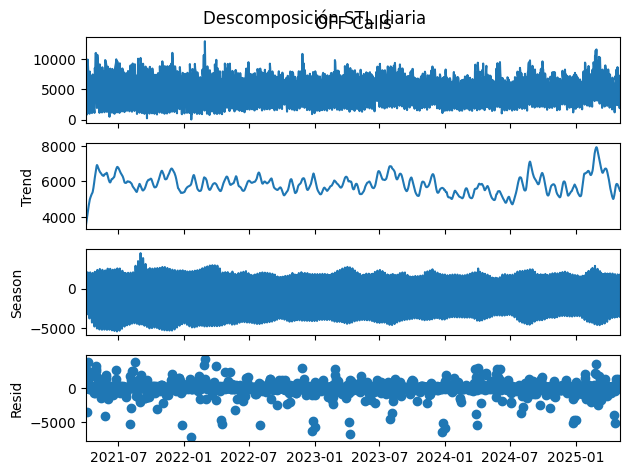

In [ ]:
## 3.2 Descomposición STL (periodo=7)
stl = STL(daily, period=7, robust=True).fit()
fig = stl.plot(); fig.suptitle('Descomposición STL diaria'); plt.show()

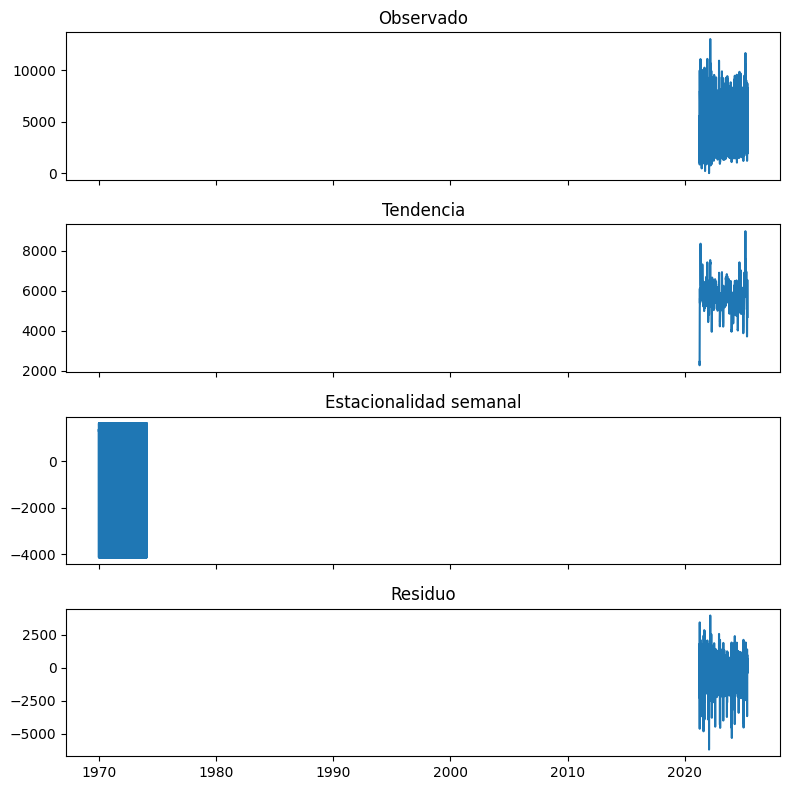

In [ ]:
## 3.3 Descomposición manual (rolling trend, estac. semanal, residuo)
trend = daily.rolling(7, center=True, min_periods=4).mean()
detr = daily - trend
seasonal_idx = detr.groupby(daily.index.dayofweek).mean()
seasonal = daily.index.dayofweek.map(seasonal_idx)
residual = daily - trend - seasonal
fig, axs = plt.subplots(4,1,figsize=(8,8), sharex=True)
axs[0].plot(daily);    axs[0].set_title('Observado')
axs[1].plot(trend);    axs[1].set_title('Tendencia')
axs[2].plot(seasonal); axs[2].set_title('Estacionalidad semanal')
axs[3].plot(residual); axs[3].set_title('Residuo')
plt.tight_layout(); plt.show()

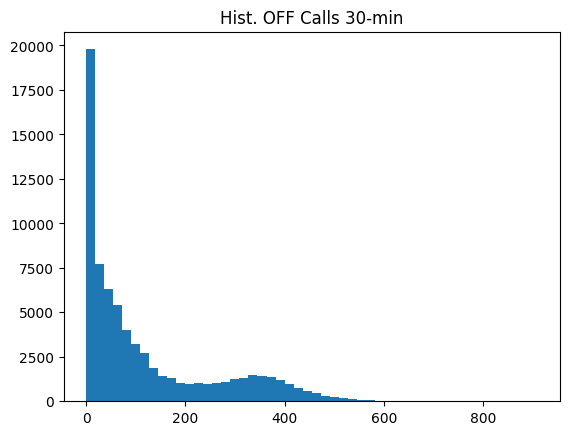

In [ ]:
# 4) Exploración intradiaria y semanal
## 4.1 Histograma 30-min
plt.figure(); plt.hist(ts, bins=50); plt.title('Hist. OFF Calls 30-min'); plt.show()

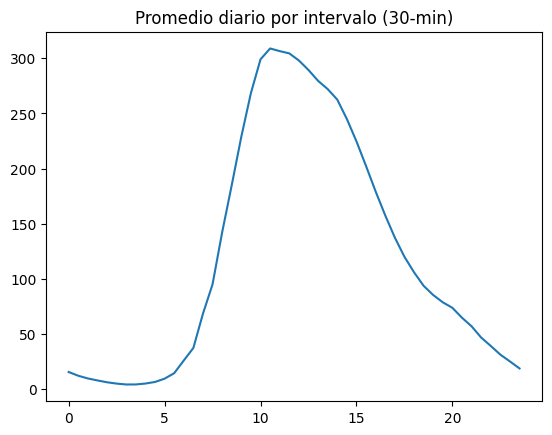

In [ ]:
## 4.2 Perfil diario promedio (48 intervalos)
profile = ts.groupby(ts.index.time).mean()
hours = [t.hour + t.minute/60 for t in profile.index]
plt.figure(); plt.plot(hours, profile.values)
plt.title('Promedio diario por intervalo (30-min)'); plt.show()

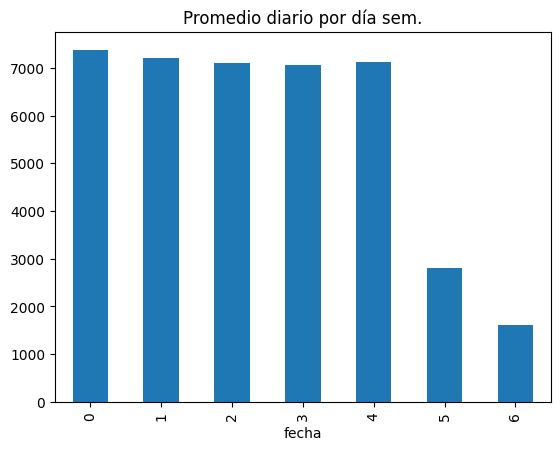

In [ ]:
## 4.3 Patrón semanal promedio (suma diaria)
weekly = daily.groupby(daily.index.dayofweek).mean()
plt.figure(); weekly.plot(kind='bar', title='Promedio diario por día sem.'); plt.show()

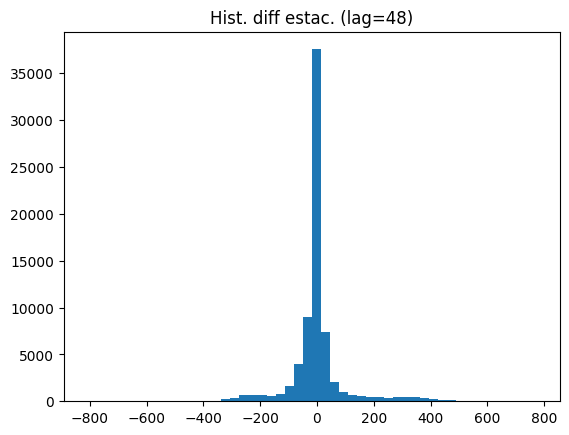

In [ ]:
## 4.4 Histograma de diferencia estacional (lag=48)
season_diff = ts.diff(48).dropna()
plt.figure(); plt.hist(season_diff, bins=50)
plt.title('Hist. diff estac. (lag=48)'); plt.show()

In [ ]:
# 5) Construcción de regresores exógenos
exog = pd.DataFrame(index=ts.index)

In [ ]:
exog

""
fecha
2021-04-01 00:00:00
2021-04-01 00:30:00
2021-04-01 01:00:00
2021-04-01 01:30:00
2021-04-01 02:00:00
...
2025-05-05 21:30:00
2025-05-05 22:00:00
2025-05-05 22:30:00


In [ ]:
exog['t'] = np.arange(len(ts))

In [ ]:
exog

,t
fecha,
2021-04-01 00:00:00,0
2021-04-01 00:30:00,1
2021-04-01 01:00:00,2
2021-04-01 01:30:00,3
2021-04-01 02:00:00,4
...,...
2025-05-05 21:30:00,71711
2025-05-05 22:00:00,71712
2025-05-05 22:30:00,71713


In [ ]:


# Dummies de hora del día
hour_series = pd.Series(ts.index.hour, index=ts.index)
exog = exog.join(pd.get_dummies(hour_series, prefix='h', drop_first=True))

# Dummies de día de la semana
dow_series = pd.Series(ts.index.dayofweek, index=ts.index)
exog = exog.join(pd.get_dummies(dow_series, prefix='d', drop_first=True))

# Dummies de mes del año
month_series = pd.Series(ts.index.month, index=ts.index)
exog = exog.join(pd.get_dummies(month_series, prefix='m', drop_first=True))

In [ ]:
exog

,t,h_1,h_2,h_3,h_4,h_5,h_6,h_7,h_8,h_9,...,m_3,m_4,m_5,m_6,m_7,m_8,m_9,m_10,m_11,m_12
fecha,,,,,,,,,,,,,,,,,,,,,
2021-04-01 00:00:00,0,False,False,False,False,False,False,False,False,False,...,False,True,False,False,False,False,False,False,False,False
2021-04-01 00:30:00,1,False,False,False,False,False,False,False,False,False,...,False,True,False,False,False,False,False,False,False,False
2021-04-01 01:00:00,2,True,False,False,False,False,False,False,False,False,...,False,True,False,False,False,False,False,False,False,False
2021-04-01 01:30:00,3,True,False,False,False,False,False,False,False,False,...,False,True,False,False,False,False,False,False,False,False
2021-04-01 02:00:00,4,False,True,False,False,False,False,False,False,False,...,False,True,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-05-05 21:30:00,71711,False,False,False,False,False,False,False,False,False,...,False,False,True,False,False,False,False,False,False,False
2025-05-05 22:00:00,71712,False,False,False,False,False,False,False,False,False,...,False,False,True,False,False,False,False,False,False,False
2025-05-05 22:30:00,71713,False,False,False,False,False,False,False,False,False,...,False,False,True,False,False,False,False,False,False,False


In [ ]:
T = 365*2; t_idx = np.arange(len(ts))
for k in (1,2):
    exog[f'sin{k}'] = np.sin(2*np.pi*k*t_idx/T)
    exog[f'cos{k}'] = np.cos(2*np.pi*k*t_idx/T)

In [ ]:
exog

,t,h_1,h_2,h_3,h_4,h_5,h_6,h_7,h_8,h_9,...,m_7,m_8,m_9,m_10,m_11,m_12,sin1,cos1,sin2,cos2
fecha,,,,,,,,,,,,,,,,,,,,,
2021-04-01 00:00:00,0,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,0.000000,1.000000,0.000000,1.000000
2021-04-01 00:30:00,1,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,0.008607,0.999963,0.017213,0.999852
2021-04-01 01:00:00,2,True,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,0.017213,0.999852,0.034422,0.999407
2021-04-01 01:30:00,3,True,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,0.025818,0.999667,0.051620,0.998667
2021-04-01 02:00:00,4,False,True,False,False,False,False,False,False,False,...,False,False,False,False,False,False,0.034422,0.999407,0.068802,0.997630
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-05-05 21:30:00,71711,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,0.995105,0.098820,0.196673,-0.980469
2025-05-05 22:00:00,71712,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,0.995919,0.090252,0.179767,-0.983709
2025-05-05 22:30:00,71713,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,0.996659,0.081676,0.162807,-0.986658


In [ ]:
# feriados y puentes
holidays = pd.to_datetime([
    '2021-01-01','2021-05-23','2021-08-01','2021-08-06','2021-10-18','2021-12-25','2021-12-26',
    '2022-01-01','2022-05-23','2022-08-01','2022-08-06','2022-10-17','2022-12-25','2022-12-26',
    '2023-01-01','2023-05-23','2023-08-01','2023-08-06','2023-10-16','2023-12-25','2023-12-26',
    '2024-01-01','2024-05-23','2024-08-01','2024-08-06','2024-10-21','2024-12-25','2024-12-26',
    '2025-01-01','2025-05-23','2025-08-01','2025-08-06','2025-10-20','2025-12-25','2025-12-26',
])
idx = exog.index
exog['is_holiday'] = idx.normalize().isin(holidays).astype(int)

In [ ]:
exog

,t,h_1,h_2,h_3,h_4,h_5,h_6,h_7,h_8,h_9,...,m_8,m_9,m_10,m_11,m_12,sin1,cos1,sin2,cos2,is_holiday
fecha,,,,,,,,,,,,,,,,,,,,,
2021-04-01 00:00:00,0,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,0.000000,1.000000,0.000000,1.000000,0
2021-04-01 00:30:00,1,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,0.008607,0.999963,0.017213,0.999852,0
2021-04-01 01:00:00,2,True,False,False,False,False,False,False,False,False,...,False,False,False,False,False,0.017213,0.999852,0.034422,0.999407,0
2021-04-01 01:30:00,3,True,False,False,False,False,False,False,False,False,...,False,False,False,False,False,0.025818,0.999667,0.051620,0.998667,0
2021-04-01 02:00:00,4,False,True,False,False,False,False,False,False,False,...,False,False,False,False,False,0.034422,0.999407,0.068802,0.997630,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-05-05 21:30:00,71711,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,0.995105,0.098820,0.196673,-0.980469,0
2025-05-05 22:00:00,71712,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,0.995919,0.090252,0.179767,-0.983709,0
2025-05-05 22:30:00,71713,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,0.996659,0.081676,0.162807,-0.986658,0


In [ ]:
exog['is_long_weekend'] = ((exog['is_holiday']==1)&idx.weekday.isin([0,4])).astype(int)

In [ ]:
exog

,t,h_1,h_2,h_3,h_4,h_5,h_6,h_7,h_8,h_9,...,m_9,m_10,m_11,m_12,sin1,cos1,sin2,cos2,is_holiday,is_long_weekend
fecha,,,,,,,,,,,,,,,,,,,,,
2021-04-01 00:00:00,0,False,False,False,False,False,False,False,False,False,...,False,False,False,False,0.000000,1.000000,0.000000,1.000000,0,0
2021-04-01 00:30:00,1,False,False,False,False,False,False,False,False,False,...,False,False,False,False,0.008607,0.999963,0.017213,0.999852,0,0
2021-04-01 01:00:00,2,True,False,False,False,False,False,False,False,False,...,False,False,False,False,0.017213,0.999852,0.034422,0.999407,0,0
2021-04-01 01:30:00,3,True,False,False,False,False,False,False,False,False,...,False,False,False,False,0.025818,0.999667,0.051620,0.998667,0,0
2021-04-01 02:00:00,4,False,True,False,False,False,False,False,False,False,...,False,False,False,False,0.034422,0.999407,0.068802,0.997630,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-05-05 21:30:00,71711,False,False,False,False,False,False,False,False,False,...,False,False,False,False,0.995105,0.098820,0.196673,-0.980469,0,0
2025-05-05 22:00:00,71712,False,False,False,False,False,False,False,False,False,...,False,False,False,False,0.995919,0.090252,0.179767,-0.983709,0,0
2025-05-05 22:30:00,71713,False,False,False,False,False,False,False,False,False,...,False,False,False,False,0.996659,0.081676,0.162807,-0.986658,0,0


In [ ]:
exog.to_csv('exog_generado.csv')

In [ ]:
exog = exog.astype(float)

In [ ]:
exog

,t,h_1,h_2,h_3,h_4,h_5,h_6,h_7,h_8,h_9,...,m_9,m_10,m_11,m_12,sin1,cos1,sin2,cos2,is_holiday,is_long_weekend
fecha,,,,,,,,,,,,,,,,,,,,,
2021-04-01 00:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,1.000000,0.000000,1.000000,0.0,0.0
2021-04-01 00:30:00,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.008607,0.999963,0.017213,0.999852,0.0,0.0
2021-04-01 01:00:00,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.017213,0.999852,0.034422,0.999407,0.0,0.0
2021-04-01 01:30:00,3.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.025818,0.999667,0.051620,0.998667,0.0,0.0
2021-04-01 02:00:00,4.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.034422,0.999407,0.068802,0.997630,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-05-05 21:30:00,71711.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.995105,0.098820,0.196673,-0.980469,0.0,0.0
2025-05-05 22:00:00,71712.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.995919,0.090252,0.179767,-0.983709,0.0,0.0
2025-05-05 22:30:00,71713.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.996659,0.081676,0.162807,-0.986658,0.0,0.0


In [ ]:
# 6) Ajuste SARIMAX(1,1,1)x(1,1,1,48) con exógenas
model = SARIMAX(ts,
                order=(1,1,1),
                seasonal_order=(1,1,1,48),
                exog=exog,
                enforce_stationarity=False,
                enforce_invertibility=False)
res = model.fit(disp=False)

# 7) Diagnóstico de residuos
print(res.summary())
resid = res.resid.dropna()
print("Ljung–Box:", acorr_ljungbox(resid, lags=[12,24,48], return_df=True))
plt.figure(); plot_acf(resid, lags=50); plt.title('ACF residuos'); plt.show()
plt.figure(); stats.probplot(resid, plot=plt); plt.title('Q-Q residuos'); plt.show()

# 8) Validación hold-out (última semana) y métricas
h = 7*48
train_ts, test_ts = ts[:-h], ts[-h:]
train_exog, test_exog = exog[:-h], exog[-h:]
pred = res.get_prediction(start=test_ts.index[0],
                          end=test_ts.index[-1],
                          exog=test_exog)
pm = pred.predicted_mean
rmse = np.sqrt(mean_squared_error(test_ts, pm))
mae  = mean_absolute_error(test_ts, pm)
mape = np.mean(np.abs((test_ts-pm)/test_ts))*100
print("AIC, BIC, RMSE, MAE, MAPE:", res.aic, res.bic, rmse, mae, mape)

# 9) Gráfico pronóstico vs observado
ci = pred.conf_int()
plt.figure(figsize=(10,5))
plt.plot(test_ts, label='Obs')
plt.plot(pm,      label='Pred')
plt.fill_between(ci.index, ci.iloc[:,0], ci.iloc[:,1], color='lightgrey', alpha=0.5)
plt.legend(); plt.title('Hold-out última semana'); plt.show()

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose, STL
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.stats.diagnostic import acorr_ljungbox
from sklearn.metrics import mean_squared_error, mean_absolute_error

# 1) Carga y preparación de la serie
df = pd.read_csv('data_jam.csv')
month_map = {
    'enero':1,'febrero':2,'marzo':3,'abril':4,
    'mayo':5,'junio':6,'julio':7,'agosto':8,
    'septiembre':9,'octubre':10,'noviembre':11,'diciembre':12
}
df['hora'] = df['Interval_Group'].str.split('-').str[0]
df['fecha'] = pd.to_datetime(
    df['DATE_S - Año'].astype(str) + '-' +
    df['DATE_S - Mes'].str.lower().map(month_map).astype(str).str.zfill(2) + '-' +
    df['DATE_S - Día'].astype(str).str.zfill(2) + ' ' + df['hora'],
    format='%Y-%m-%d %H:%M'
)
df['OFF Calls'] = pd.to_numeric(df['OFF Calls'], errors='coerce')
df = df.dropna(subset=['OFF Calls'])
ts = df.set_index('fecha')['OFF Calls'].sort_index()

# 2) Análisis previo
## 2.1 Valores faltantes y descriptivos
print("Missing:", ts.isnull().sum())
print(ts.describe())

## 2.2 Serie de tiempo
plt.figure(); ts.plot(title='Serie de tiempo OFF Calls'); plt.show()

## 2.3 Prueba ADF (serie original)
adf_stat, pval, *_ = adfuller(ts)
print(f"ADF: {adf_stat:.3f}, p-value: {pval:.3f}")

## 2.4 ACF/PACF de la serie
plt.figure(); plot_acf(ts, lags=50); plt.title('ACF OFF Calls'); plt.show()
plt.figure(); plot_pacf(ts, lags=50, method='ywm'); plt.title('PACF OFF Calls'); plt.show()

# 3) Muestreo diario y descomposición
daily = ts.resample('D').sum()
plt.figure(); daily.plot(title='Suma diaria OFF Calls'); plt.show()

## 3.1 ADF en diaria
adf_stat_d, pval_d, *_ = adfuller(daily.dropna())
print(f"ADF diaria: {adf_stat_d:.3f}, p-value: {pval_d:.3f}")

## 3.2 Descomposición STL (periodo=7)
stl = STL(daily, period=7, robust=True).fit()
fig = stl.plot(); fig.suptitle('Descomposición STL diaria'); plt.show()

## 3.3 Descomposición manual (rolling trend, estac. semanal, residuo)
trend = daily.rolling(7, center=True, min_periods=4).mean()
detr = daily - trend
seasonal_idx = detr.groupby(daily.index.dayofweek).mean()
seasonal = daily.index.dayofweek.map(seasonal_idx)
residual = daily - trend - seasonal
fig, axs = plt.subplots(4,1,figsize=(8,8), sharex=True)
axs[0].plot(daily);    axs[0].set_title('Observado')
axs[1].plot(trend);    axs[1].set_title('Tendencia')
axs[2].plot(seasonal); axs[2].set_title('Estacionalidad semanal')
axs[3].plot(residual); axs[3].set_title('Residuo')
plt.tight_layout(); plt.show()

# 4) Exploración intradiaria y semanal
## 4.1 Histograma 30-min
plt.figure(); plt.hist(ts, bins=50); plt.title('Hist. OFF Calls 30-min'); plt.show()

## 4.2 Perfil diario promedio (48 intervalos)
profile = ts.groupby(ts.index.time).mean()
hours = [t.hour + t.minute/60 for t in profile.index]
plt.figure(); plt.plot(hours, profile.values)
plt.title('Promedio diario por intervalo (30-min)'); plt.show()

## 4.3 Patrón semanal promedio (suma diaria)
weekly = daily.groupby(daily.index.dayofweek).mean()
plt.figure(); weekly.plot(kind='bar', title='Promedio diario por día sem.'); plt.show()

## 4.4 Histograma de diferencia estacional (lag=48)
season_diff = ts.diff(48).dropna()
plt.figure(); plt.hist(season_diff, bins=50)
plt.title('Hist. diff estac. (lag=48)'); plt.show()

# 5) Construcción de regresores exógenos
exog = pd.DataFrame(index=ts.index)
exog['t'] = np.arange(len(ts))

# dummies hora/día/mes
# Dummies de hora del día
hour_series = pd.Series(ts.index.hour, index=ts.index)
exog = exog.join(pd.get_dummies(hour_series, prefix='h', drop_first=True))

# Dummies de día de la semana
dow_series = pd.Series(ts.index.dayofweek, index=ts.index)
exog = exog.join(pd.get_dummies(dow_series, prefix='d', drop_first=True))

# Dummies de mes del año
month_series = pd.Series(ts.index.month, index=ts.index)
exog = exog.join(pd.get_dummies(month_series, prefix='m', drop_first=True))

# Fourier anual (T=365×2)
T = 365*2; t_idx = np.arange(len(ts))
for k in (1,2):
    exog[f'sin{k}'] = np.sin(2*np.pi*k*t_idx/T)
    exog[f'cos{k}'] = np.cos(2*np.pi*k*t_idx/T)
# feriados y puentes
holidays = pd.to_datetime([
    '2021-01-01','2021-05-23','2021-08-01','2021-08-06','2021-10-18','2021-12-25','2021-12-26',
    '2022-01-01','2022-05-23','2022-08-01','2022-08-06','2022-10-17','2022-12-25','2022-12-26',
    '2023-01-01','2023-05-23','2023-08-01','2023-08-06','2023-10-16','2023-12-25','2023-12-26',
    '2024-01-01','2024-05-23','2024-08-01','2024-08-06','2024-10-21','2024-12-25','2024-12-26',
    '2025-01-01','2025-05-23','2025-08-01','2025-08-06','2025-10-20','2025-12-25','2025-12-26',
])
idx = exog.index
exog['is_holiday'] = idx.normalize().isin(holidays).astype(int)
exog['is_long_weekend'] = ((exog['is_holiday']==1)&idx.weekday.isin([0,4])).astype(int)
exog = exog.astype(float)

# 6) Ajuste SARIMAX(1,1,1)x(1,1,1,48) con exógenas
model = SARIMAX(ts,
                order=(1,1,1),
                seasonal_order=(1,1,1,48),
                exog=exog,
                enforce_stationarity=False,
                enforce_invertibility=False)
res = model.fit(disp=False)

# 7) Diagnóstico de residuos
print(res.summary())
resid = res.resid.dropna()
print("Ljung–Box:", acorr_ljungbox(resid, lags=[12,24,48], return_df=True))
plt.figure(); plot_acf(resid, lags=50); plt.title('ACF residuos'); plt.show()
plt.figure(); stats.probplot(resid, plot=plt); plt.title('Q-Q residuos'); plt.show()

# 8) Validación hold-out (última semana) y métricas
h = 7*48
train_ts, test_ts = ts[:-h], ts[-h:]
train_exog, test_exog = exog[:-h], exog[-h:]
pred = res.get_prediction(start=test_ts.index[0],
                          end=test_ts.index[-1],
                          exog=test_exog)
pm = pred.predicted_mean
rmse = np.sqrt(mean_squared_error(test_ts, pm))
mae  = mean_absolute_error(test_ts, pm)
mape = np.mean(np.abs((test_ts-pm)/test_ts))*100
print("AIC, BIC, RMSE, MAE, MAPE:", res.aic, res.bic, rmse, mae, mape)

# 9) Gráfico pronóstico vs observado
ci = pred.conf_int()
plt.figure(figsize=(10,5))
plt.plot(test_ts, label='Obs')
plt.plot(pm,      label='Pred')
plt.fill_between(ci.index, ci.iloc[:,0], ci.iloc[:,1], color='lightgrey', alpha=0.5)
plt.legend(); plt.title('Hold-out última semana'); plt.show()